# Spark Initialisation

In [1]:
from pyspark.sql import SparkSession
from time import time
spark = SparkSession.builder \
 .appName('DATA301 GDELT Project') \
 .config('spark.jars.packages', "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.24.2") \
 .getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 10)

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-bdb9d5c0-2157-4037-899c-0495ca2da5fd;1.0
	confs: [default]
	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.24.2 in central
:: resolution report :: resolve 267ms :: artifacts dl 4ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.24.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrie

# Reading BigQuery Data

In [2]:
# Read documents from BigQuery table
docs = spark.read.format('bigquery').load("data301-345604.GKG_Public_Transport.2020-05-03")
docs

DATE,DocumentIdentifier,Themes,V2Tone,Locations
20200723193000,https://rp-online...,GEN_HOLIDAY;TAX_E...,-1.43436233239788...,1#Malta#MT#MT#35....
20220124090000,https://www.cotid...,TAX_FNCACT;TAX_FN...,-6.01503759398496...,"4#Bucharest, Bucu..."
20220124090000,https://www.haber...,WB_2433_CONFLICT_...,-0.65252854812398...,"4#Black Sea, Ocea..."
20200721063000,https://www.myjou...,TAX_FNCACT;TAX_FN...,-3.40236686390533...,"4#Seoul, Soul-T'u..."
20220123021500,https://www.lokma...,KILL;CRISISLEX_T0...,-5.55555555555556...,"4#Mumbai, Maharas..."
20220124204500,https://www.tivys...,TAX_ETHNICITY;TAX...,-2.27272727272727...,1#Colombia#CO#CO#...
20200902160000,https://www.pulse...,TAX_FNCACT;TAX_FN...,-4.10958904109589...,"4#Kano, Kano, Nig..."
20200511223000,http://www.singap...,TAX_FNCACT;TAX_FN...,-0.44493882091212...,"4#Chengdu, Sichua..."
20200511224500,https://english.a...,TAX_FNCACT;TAX_FN...,-4.46859903381642...,1#Mexico#MX#MX#23...
20200511223000,https://finance.s...,EPU_ECONOMY_HISTO...,0.135685210312076...,1#China#CH#CH#35#...


# Transforming Data For Clustering

In [3]:
from pyspark.sql.functions import split, explode
docs_split = docs.withColumn("Locations", split("Locations", ";")) # Split each location block
docs_one_loc = docs_split.select("V2Tone", "DocumentIdentifier", explode('Locations').alias("Location")).cache() # One-row-per-location
docs_one_loc

V2Tone,DocumentIdentifier,Location
-1.43436233239788...,https://rp-online...,1#Malta#MT#MT#35....
-1.43436233239788...,https://rp-online...,"5#Carinthia, KäTe..."
-1.43436233239788...,https://rp-online...,1#United States#U...
-1.43436233239788...,https://rp-online...,"4#Paris, France (..."
-1.43436233239788...,https://rp-online...,1#United Kingdom#...
-1.43436233239788...,https://rp-online...,1#Portugal#PO#PO#...
-1.43436233239788...,https://rp-online...,1#Czech Republic#...
-1.43436233239788...,https://rp-online...,1#Austria#AU#AU#4...
-1.43436233239788...,https://rp-online...,"4#Dublin, Dublin,..."
-1.43436233239788...,https://rp-online...,1#Egypt#EG#EG#27#...


In [4]:
docs_loc_split = docs_one_loc.select("V2Tone", "DocumentIdentifier", split("Location", "#").alias("Location")) # Split the location sub-fields
docs_latlng = docs_loc_split.select("V2Tone", "DocumentIdentifier", docs_loc_split["Location"].getItem(4).cast("float").alias("Latitude"), docs_loc_split["Location"].getItem(5).cast("float").alias("Longitude")).cache() # Extract location lat/lng data
docs_latlng

V2Tone,DocumentIdentifier,Latitude,Longitude
-1.43436233239788...,https://rp-online...,35.916668,14.433333
-1.43436233239788...,https://rp-online...,46.75,13.8333
-1.43436233239788...,https://rp-online...,39.828175,-98.5795
-1.43436233239788...,https://rp-online...,48.8667,2.33333
-1.43436233239788...,https://rp-online...,54.0,-4.0
-1.43436233239788...,https://rp-online...,39.5,-8.0
-1.43436233239788...,https://rp-online...,49.75,15.0
-1.43436233239788...,https://rp-online...,47.333332,13.333333
-1.43436233239788...,https://rp-online...,53.3331,-6.24889
-1.43436233239788...,https://rp-online...,27.0,30.0


In [5]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["Latitude", "Longitude"], outputCol="Features").setHandleInvalid("skip") # Create a location vector assembler
docs_vector = assembler.transform(docs_latlng).cache() # Apply the vector assembler to the documents DF
docs_vector

V2Tone,DocumentIdentifier,Latitude,Longitude,Features
-1.43436233239788...,https://rp-online...,35.916668,14.433333,[35.9166679382324...
-1.43436233239788...,https://rp-online...,46.75,13.8333,"[46.75,13.8332996..."
-1.43436233239788...,https://rp-online...,39.828175,-98.5795,[39.8281745910644...
-1.43436233239788...,https://rp-online...,48.8667,2.33333,"[48.86669921875,2..."
-1.43436233239788...,https://rp-online...,54.0,-4.0,"[54.0,-4.0]"
-1.43436233239788...,https://rp-online...,39.5,-8.0,"[39.5,-8.0]"
-1.43436233239788...,https://rp-online...,49.75,15.0,"[49.75,15.0]"
-1.43436233239788...,https://rp-online...,47.333332,13.333333,[47.3333320617675...
-1.43436233239788...,https://rp-online...,53.3331,-6.24889,[53.3330993652343...
-1.43436233239788...,https://rp-online...,27.0,30.0,"[27.0,30.0]"


# Performing K-Means Clustering

In [6]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol="Features", predictionCol="Prediction")
ks = [50, 100, 200, 400, 800, 1200, 1600]
silhouettes = []
times = []

for k in ks:
    start_time = time()
    
    kmeans = KMeans(featuresCol='Features', predictionCol='Prediction', k=k)
    model = kmeans.fit(docs_vector)
    transformed = model.transform(docs_vector)
    
    end_time = time()
    times.append(end_time - start_time)
    
    silhouette = evaluator.evaluate(transformed)
    silhouettes.append(silhouette)

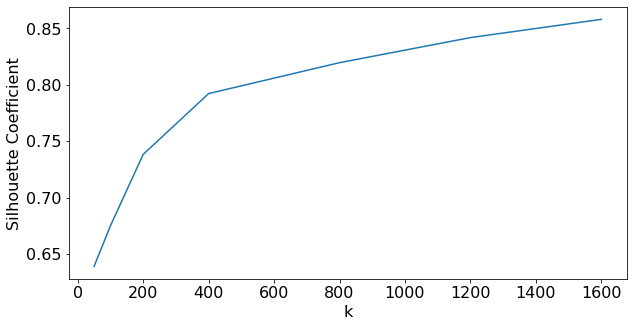

In [200]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ks, silhouettes)
ax.set_xlabel("k")
ax.set_ylabel("Silhouette Coefficient");

In [202]:
fig.savefig("silhouette3.svg")

22/06/02 05:27:30 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_1274_12 !
22/06/02 05:27:30 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_1260_12 !
22/06/02 05:27:30 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_1274_11 !
22/06/02 05:27:30 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_1290_12 !
22/06/02 05:27:30 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_1290_11 !
22/06/02 05:27:30 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_1260_11 !
22/06/02 05:27:30 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 9 for reason Container marked as failed: container_1654065237515_0001_01_000009 on host: data301-gdelt-project-w-2.australia-southeast1

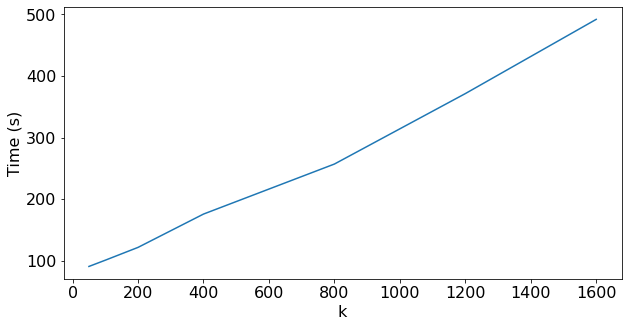

In [198]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ks, times)
ax.set_xlabel("k")
ax.set_ylabel("Time (s)");

In [199]:
fig.savefig("time.svg")

The local maxima was selected for k = 1200:

In [ ]:
start_time = time()

kmeans = KMeans(featuresCol='Features', predictionCol='Prediction', k=1200)
model = kmeans.fit(docs_vector)
transformed = model.transform(docs_vector)

end_time = time()
print(f"Execution time: {(end_time - start_time):.0f} s")
transformed

22/06/02 07:02:30 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_11_0 !
22/06/02 07:02:30 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_66_1 !
22/06/02 07:02:30 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_11_2 !
22/06/02 07:02:30 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_25_0 !
22/06/02 07:02:30 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_11_1 !
22/06/02 07:02:30 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_25_1 !
22/06/02 07:02:30 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_41_1 !
22/06/02 07:02:30 WARN org.apache.spark.storage.BlockManagerMasterEndpoint: No more replicas available for rdd_41_0 !
22/06/02 07:02:30 WARN org.apache.spark.storage.BlockMan

KeyboardInterrupt: 

# Verifying Clustering Results

In [ ]:
cluster_centers = model.clusterCenters()
cluster_centers[:10]

In [115]:
summary = model.summary
cluster_sizes = summary.clusterSizes
cluster_sizes[:10]

[75588, 14731, 56439, 14898, 20077, 36729, 20061, 7610, 5774, 3075]

# Performing Aggregate Statistics

In [116]:
# Split the tone sub-fields
docs_tone_split = transformed.select("Prediction", "DocumentIdentifier", split("V2Tone", ",").alias("Tone"))
docs_emotions = docs_tone_split.select(
    "Prediction",
    "DocumentIdentifier",
    docs_tone_split["Tone"].getItem(0).cast("float").alias("Tone"),
    docs_tone_split["Tone"].getItem(1).cast("float").alias("Positive"),
    docs_tone_split["Tone"].getItem(2).cast("float").alias("Negative"),
    docs_tone_split["Tone"].getItem(3).cast("float").alias("Polarity")
).cache()
docs_emotions

22/06/01 10:16:12 WARN org.apache.spark.sql.execution.CacheManager: Asked to cache already cached data.


Prediction,DocumentIdentifier,Tone,Positive,Negative,Polarity
339,https://rp-online...,-1.4343623,1.8085438,3.242906,5.05145
1157,https://rp-online...,-1.4343623,1.8085438,3.242906,5.05145
35,https://rp-online...,-1.4343623,1.8085438,3.242906,5.05145
175,https://rp-online...,-1.4343623,1.8085438,3.242906,5.05145
88,https://rp-online...,-1.4343623,1.8085438,3.242906,5.05145
90,https://rp-online...,-1.4343623,1.8085438,3.242906,5.05145
37,https://rp-online...,-1.4343623,1.8085438,3.242906,5.05145
77,https://rp-online...,-1.4343623,1.8085438,3.242906,5.05145
196,https://rp-online...,-1.4343623,1.8085438,3.242906,5.05145
227,https://rp-online...,-1.4343623,1.8085438,3.242906,5.05145


Compute average statistics for tone and polarity

In [117]:
grouped_by_cluster = docs_emotions.groupBy("Prediction")
avg_emotions = grouped_by_cluster.avg("Tone", "Polarity", "Positive", "Negative")
avg_emotions

Prediction,avg(Tone),avg(Polarity),avg(Positive),avg(Negative)
148,-1.057301652514975,6.003772228014633,2.4732352865665415,3.530536938176402
471,-1.1462892154298365,5.907902653110778,2.380806722108039,3.5270959380620805
463,-2.135326917648832,5.761587878844863,1.8131304792341243,3.948457395647181
1088,-2.0485751223586335,7.575946356374632,2.763685618921486,4.812260746785784
833,-0.5583047259803096,6.438458654034424,2.9400769413436114,3.4983816871623676
496,-0.7512682955948576,5.561690830712151,2.40521126710079,3.156479584858192
858,-1.9243453240271458,6.33619851031222,2.205926593117051,4.1302719199835565
540,-1.8543595575889826,5.572268829953874,1.858954632868801,3.7133141996819217
623,-1.816454755717308,6.063993046512462,2.123769144338743,3.9402238987490907
1084,-0.1993595763869521,7.66071918422429,3.7306798065891367,3.930039379188434


Obtain cluster size and cluster centers

In [118]:
prediction_size_center = [(i, size, [float(lat), float(lng)]) for i, (size, (lat, lng)) in enumerate(zip(cluster_sizes, cluster_centers))]
cluster_metadata = spark.createDataFrame(prediction_size_center, ["Prediction", "ClusterSize", "ClusterCenter"])
cluster_metadata

Prediction,ClusterSize,ClusterCenter
0,75588,[59.8887212192809...
1,14731,[48.4009419913107...
2,56439,[29.7361093126495...
3,14898,[15.9236376403658...
4,20077,[-1.6859633929072...
5,36729,[-27.321767176105...
6,20061,[25.0067393069644...
7,7610,[17.4983724516418...
8,5774,[39.0615714766552...
9,3075,[53.9385067562940...


In [119]:
avg_emotions_metadata = avg_emotions.join(cluster_metadata, on="Prediction").cache()
avg_emotions_metadata

Prediction,avg(Tone),avg(Polarity),avg(Positive),avg(Negative),ClusterSize,ClusterCenter
26,-2.3845179774235903,6.7616123139459665,2.188547168860051,4.573065140683522,13683,[-18.097640640770...
29,-1.9371450108647865,6.707854637849022,2.3853548133779734,4.322499826573499,99546,[32.9683437874133...
474,-2.0301580782639297,7.584567173187166,2.777204539020545,4.807362622559538,2298,[4.30895096774304...
964,-2.6816693292896,6.78819381901793,2.053262255935861,4.734931591939873,1341,[50.9513021635529...
65,-2.451042168731964,6.382689156217738,1.965823494020882,4.416865661683614,48366,[27.0633508611424...
191,-3.398734648223184,7.48466181931282,2.042963586656813,5.4416982409831265,6562,[29.3185087902739...
418,-1.6590075312040404,6.605393914156663,2.4731931920146075,4.1322007220087595,21855,[35.0538521633353...
541,-1.85842272103375,6.358516426669665,2.250046852471693,4.108469573961815,76649,[39.1201539871428...
558,-2.3059371705696234,6.896285807065795,2.295174317491739,4.601111488435725,393688,[42.1658730052549...
1010,-2.634433039299033,6.978564604198619,2.172065780160182,4.806498832672042,15644,[34.4811819308677...


Convert Spark DataFrame to Pandas DataFrame

In [120]:
pandas_df = avg_emotions_metadata.toPandas()
pandas_df['Latitude'], pandas_df['Longitude'] = zip(*pandas_df["ClusterCenter"])
pandas_df.drop(columns=["ClusterCenter"], inplace=True)
pandas_df

,Prediction,avg(Tone),avg(Polarity),avg(Positive),avg(Negative),ClusterSize,Latitude,Longitude
0,26,-2.384518,6.761612,2.188547,4.573065,13683,-18.097641,31.163248
1,29,-1.937145,6.707855,2.385355,4.322500,99546,32.968344,-83.648950
2,474,-2.030158,7.584567,2.777205,4.807363,2298,4.308951,31.798211
3,964,-2.681669,6.788194,2.053262,4.734932,1341,50.951302,58.275147
4,65,-2.451042,6.382689,1.965823,4.416866,48366,27.063351,80.859625
...,...,...,...,...,...,...,...,...
1195,1092,-3.836765,6.775292,1.469263,5.306028,5945,51.171237,23.520814
1196,1147,-1.913730,6.197339,2.141804,4.055534,2338,36.554877,27.108437
1197,211,-0.743453,6.241399,2.748973,3.492426,3792,-36.622019,146.812897
1198,469,-1.628481,6.394803,2.383161,4.011642,10281,-12.902222,-39.502686


## Geographic Plots

Convert DataFrame to GeoDataFrame

In [121]:
import geopandas as gpd
geo_df = gpd.GeoDataFrame(pandas_df, geometry=gpd.points_from_xy(pandas_df["Longitude"], pandas_df["Latitude"]))
geo_df

,Prediction,avg(Tone),avg(Polarity),avg(Positive),avg(Negative),ClusterSize,Latitude,Longitude,geometry
0,26,-2.384518,6.761612,2.188547,4.573065,13683,-18.097641,31.163248,POINT (31.16325 -18.09764)
1,29,-1.937145,6.707855,2.385355,4.322500,99546,32.968344,-83.648950,POINT (-83.64895 32.96834)
2,474,-2.030158,7.584567,2.777205,4.807363,2298,4.308951,31.798211,POINT (31.79821 4.30895)
3,964,-2.681669,6.788194,2.053262,4.734932,1341,50.951302,58.275147,POINT (58.27515 50.95130)
4,65,-2.451042,6.382689,1.965823,4.416866,48366,27.063351,80.859625,POINT (80.85963 27.06335)
...,...,...,...,...,...,...,...,...,...
1195,1092,-3.836765,6.775292,1.469263,5.306028,5945,51.171237,23.520814,POINT (23.52081 51.17124)
1196,1147,-1.913730,6.197339,2.141804,4.055534,2338,36.554877,27.108437,POINT (27.10844 36.55488)
1197,211,-0.743453,6.241399,2.748973,3.492426,3792,-36.622019,146.812897,POINT (146.81290 -36.62202)
1198,469,-1.628481,6.394803,2.383161,4.011642,10281,-12.902222,-39.502686,POINT (-39.50269 -12.90222)


### Average Tone Plot

NameError: name 'gpd' is not defined

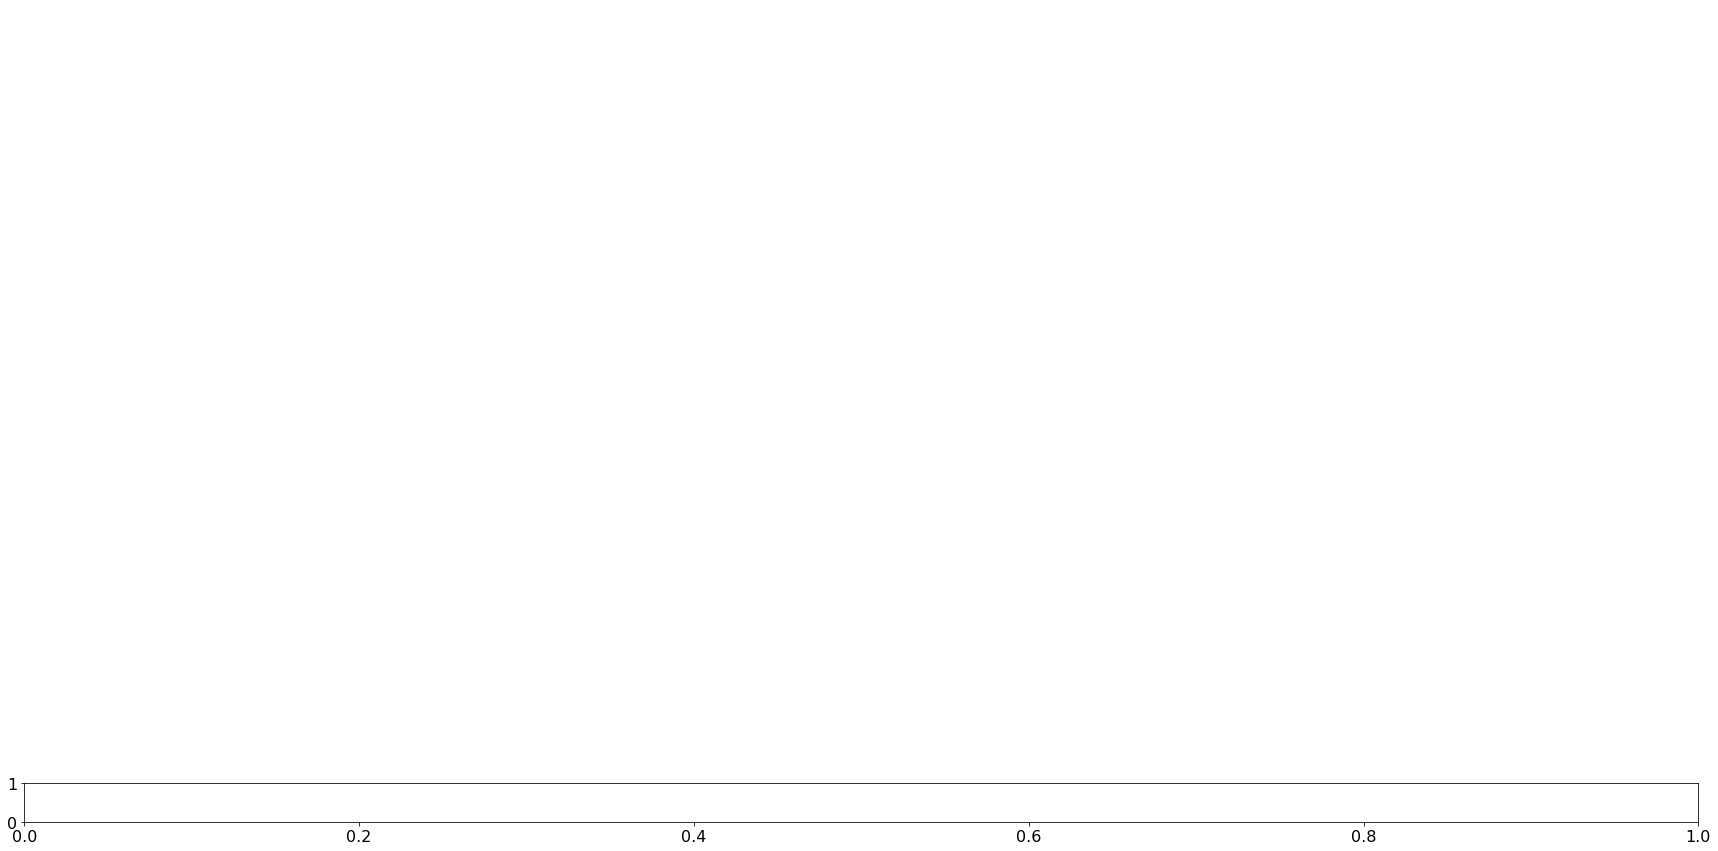

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["font.size"] = 16

fig, ax = plt.subplots(figsize=(30, 15))
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='white', edgecolor='black')
geo_df.plot(ax=ax, column="avg(Tone)", markersize=geo_df["ClusterSize"] / 2e3, legend=True, legend_kwds={'label': "Average Tone", "orientation": "horizontal"}, alpha=0.7, cax=cax);

In [157]:
fig.savefig("tone.svg")

### Average Polarity plot

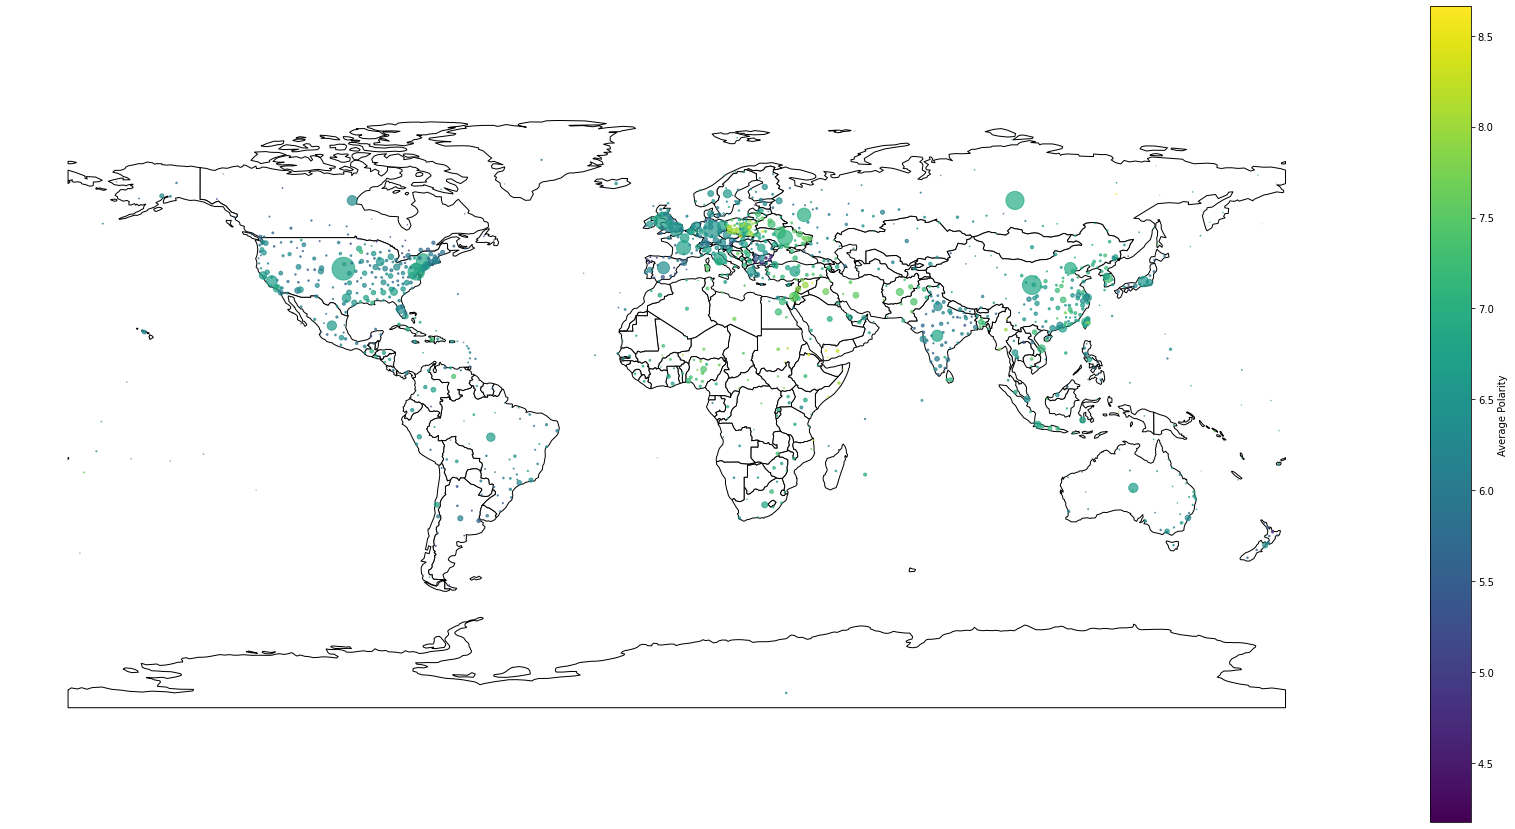

In [102]:
fig, ax = plt.subplots(figsize=(30, 15))
ax.set_axis_off()

world.plot(ax=ax, color='white', edgecolor='black')
geo_df.plot(ax=ax, column="avg(Polarity)", markersize=geo_df["ClusterSize"] / 2e3, legend=True, legend_kwds={'label': "Average Polarity"}, alpha=0.7);

In [41]:
fig.savefig("polarity.svg")

### Average Negative Score Plot

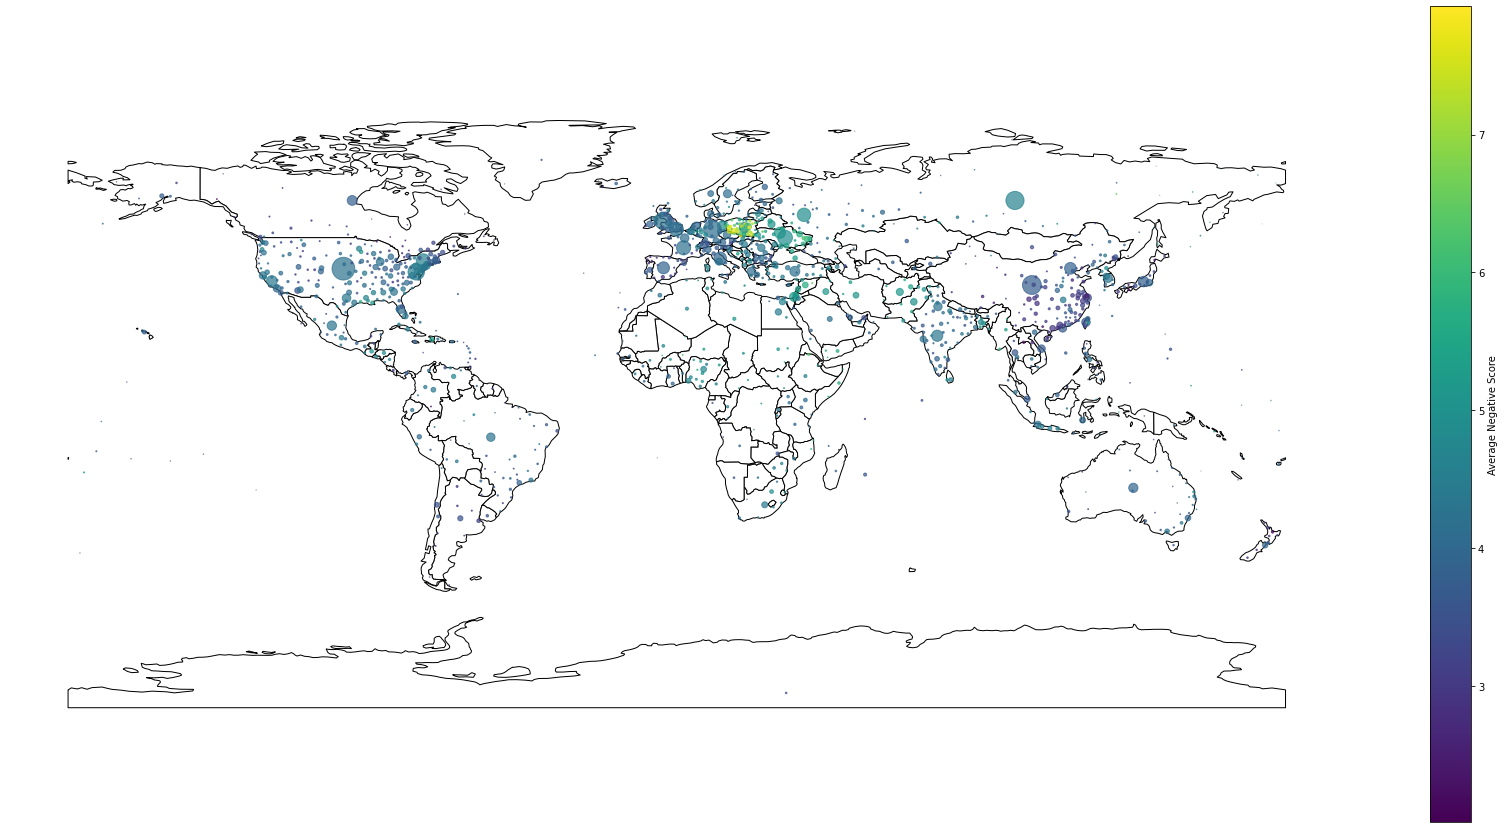

In [103]:
fig, ax = plt.subplots(figsize=(30, 15))
ax.set_axis_off()

world.plot(ax=ax, color='white', edgecolor='black')
geo_df.plot(ax=ax, column="avg(Negative)", markersize=geo_df["ClusterSize"] / 2e3, legend=True, legend_kwds={'label': "Average Negative Score"}, alpha=0.7);

### Average Positive Score Plot

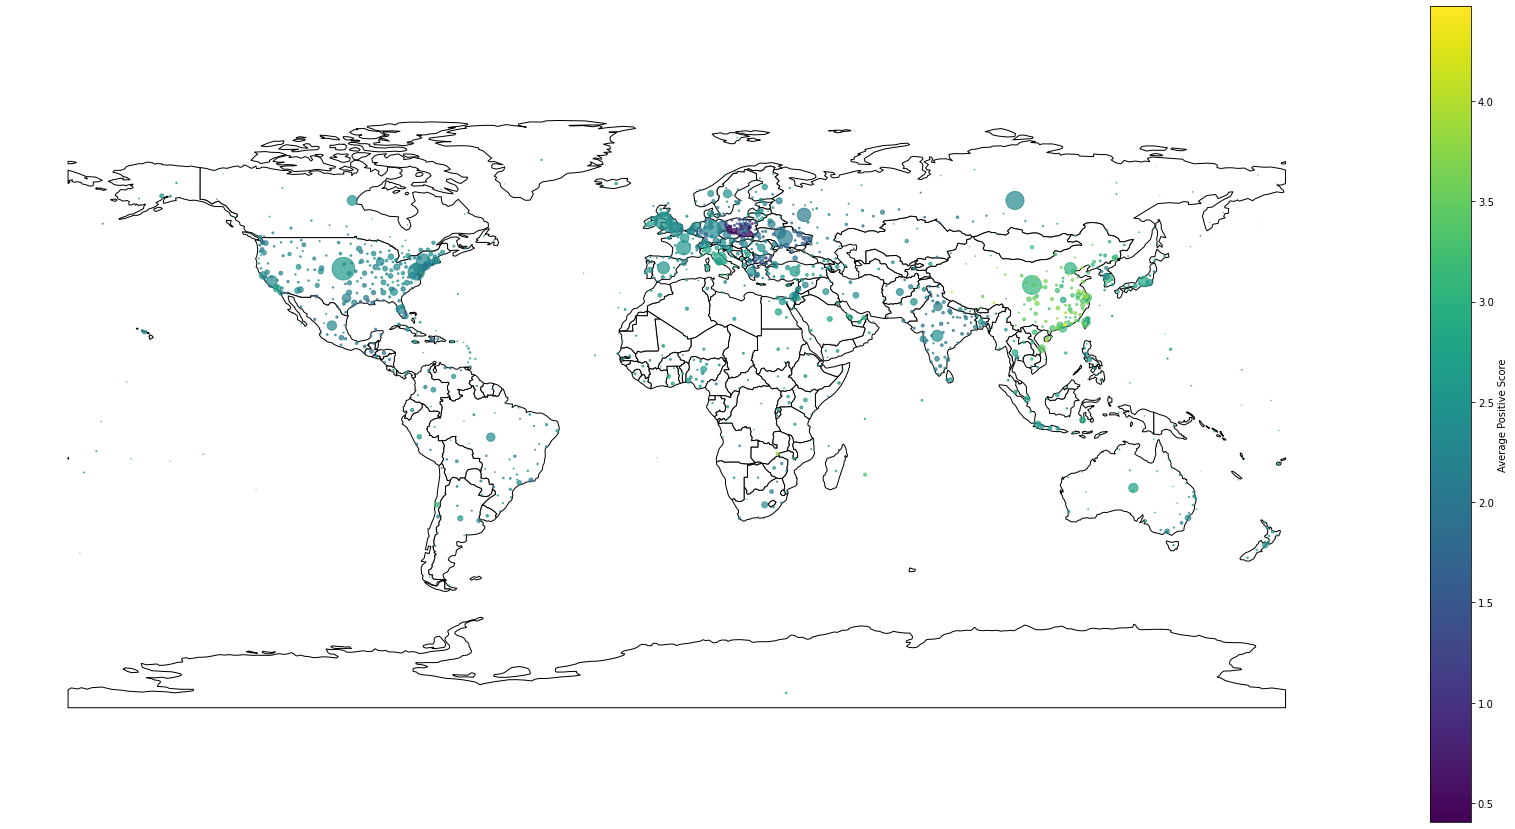

In [104]:
fig, ax = plt.subplots(figsize=(30, 15))
ax.set_axis_off()

world.plot(ax=ax, color='white', edgecolor='black')
geo_df.plot(ax=ax, column="avg(Positive)", markersize=geo_df["ClusterSize"] / 2e3, legend=True, legend_kwds={'label': "Average Positive Score"}, alpha=0.7);

## Collecting Insights

In [131]:
tone_asc = avg_emotions_metadata.sort("avg(Tone)")
tone_asc.tail(30)

[Row(Prediction=243, avg(Tone)=0.5391279432809862, avg(Polarity)=6.792070718555231, avg(Positive)=3.665599330483415, avg(Negative)=3.1264713877773382, ClusterSize=17736, ClusterCenter=[26.175058979035285, 119.28084666243963]),
 Row(Prediction=1005, avg(Tone)=0.5443448556654445, avg(Polarity)=6.595278419130309, avg(Positive)=3.5698116377846727, avg(Negative)=3.025466782962292, ClusterSize=10510, ClusterCenter=[20.51348950833394, 110.25633222396662]),
 Row(Prediction=1079, avg(Tone)=0.5583489891694141, avg(Polarity)=7.820625947926382, avg(Positive)=4.1894874699837805, avg(Negative)=3.631138485258086, ClusterSize=9541, ClusterCenter=[26.692599587340034, 114.92620423479583]),
 Row(Prediction=950, avg(Tone)=0.5685353368848353, avg(Polarity)=7.081976109149327, avg(Positive)=3.825255719344044, avg(Negative)=3.2567203852264424, ClusterSize=7664, ClusterCenter=[29.734494281213316, 120.69410405029582]),
 Row(Prediction=1008, avg(Tone)=0.6113817902418265, avg(Polarity)=6.979271733578812, avg(Posi

In [133]:
docs_emotions.filter(docs_emotions["Prediction"] == 243).sort("Tone").select("DocumentIdentifier").tail(100)

[Row(DocumentIdentifier='https://finance.sina.com.cn/stock/relnews/cn/2020-08-11/doc-iivhuipn8047950.shtml'),
 Row(DocumentIdentifier='http://news.fznews.com.cn/dsxw/20210519/60a47ef10e81f.shtml'),
 Row(DocumentIdentifier='http://news.fznews.com.cn/dsxw/20201205/5fcadf6d4b746.shtml'),
 Row(DocumentIdentifier='http://news.fznews.com.cn/dsxw/20220123/61ed7052d8f14.shtml'),
 Row(DocumentIdentifier='http://news.fznews.com.cn/dsxw/20220123/61ed7052d8f14.shtml'),
 Row(DocumentIdentifier='http://news.jstv.com/a/20201230/1609380200244.shtml'),
 Row(DocumentIdentifier='http://news.fznews.com.cn/dsxw/20220125/61ef71667cb8a.shtml'),
 Row(DocumentIdentifier='http://news.fznews.com.cn/dsxw/20211021/6170e22a55fbd.shtml'),
 Row(DocumentIdentifier='https://m.tech.china.com/redian/2021/1104/112021_916255.html'),
 Row(DocumentIdentifier='http://fjnews.fjsen.com/2022-01/24/content_30945250.htm'),
 Row(DocumentIdentifier='http://www.ce.cn/culture/gd/202103/18/t20210318_36390170.shtml'),
 Row(DocumentIdent

In [80]:
tone_asc.tail(10)

[Row(Prediction=270, avg(Tone)=1.016323271215307, avg(Polarity)=5.884874901491557, avg(Positive)=3.450599083623438, avg(Negative)=2.4342758149169517, ClusterSize=6511, ClusterCenter=[22.690212816599605, 108.18596810053945]),
 Row(Prediction=582, avg(Tone)=1.0235159728927476, avg(Polarity)=5.263949091282163, avg(Positive)=3.1437325281207316, avg(Negative)=2.120216559179675, ClusterSize=10284, ClusterCenter=[18.101957643602386, 102.57092279518035]),
 Row(Prediction=802, avg(Tone)=1.0312165529384405, avg(Polarity)=6.783027935095773, avg(Positive)=3.9071222452012155, avg(Negative)=2.8759056898828046, ClusterSize=9509, ClusterCenter=[31.564754919143788, 120.22353148412749]),
 Row(Prediction=684, avg(Tone)=1.0536902142631304, avg(Polarity)=6.899392231390572, avg(Positive)=3.976541224914318, avg(Negative)=2.9228510130050678, ClusterSize=3314, ClusterCenter=[37.90276094251321, 115.70864529054282]),
 Row(Prediction=908, avg(Tone)=1.0630017467324746, avg(Polarity)=6.780657070459699, avg(Positive

22/06/02 10:20:54 WARN org.apache.spark.deploy.yarn.YarnAllocatorNodeHealthTracker: No available nodes reported, please check Resource Manager.


NameError: name 'make_axes_locatable' is not defined

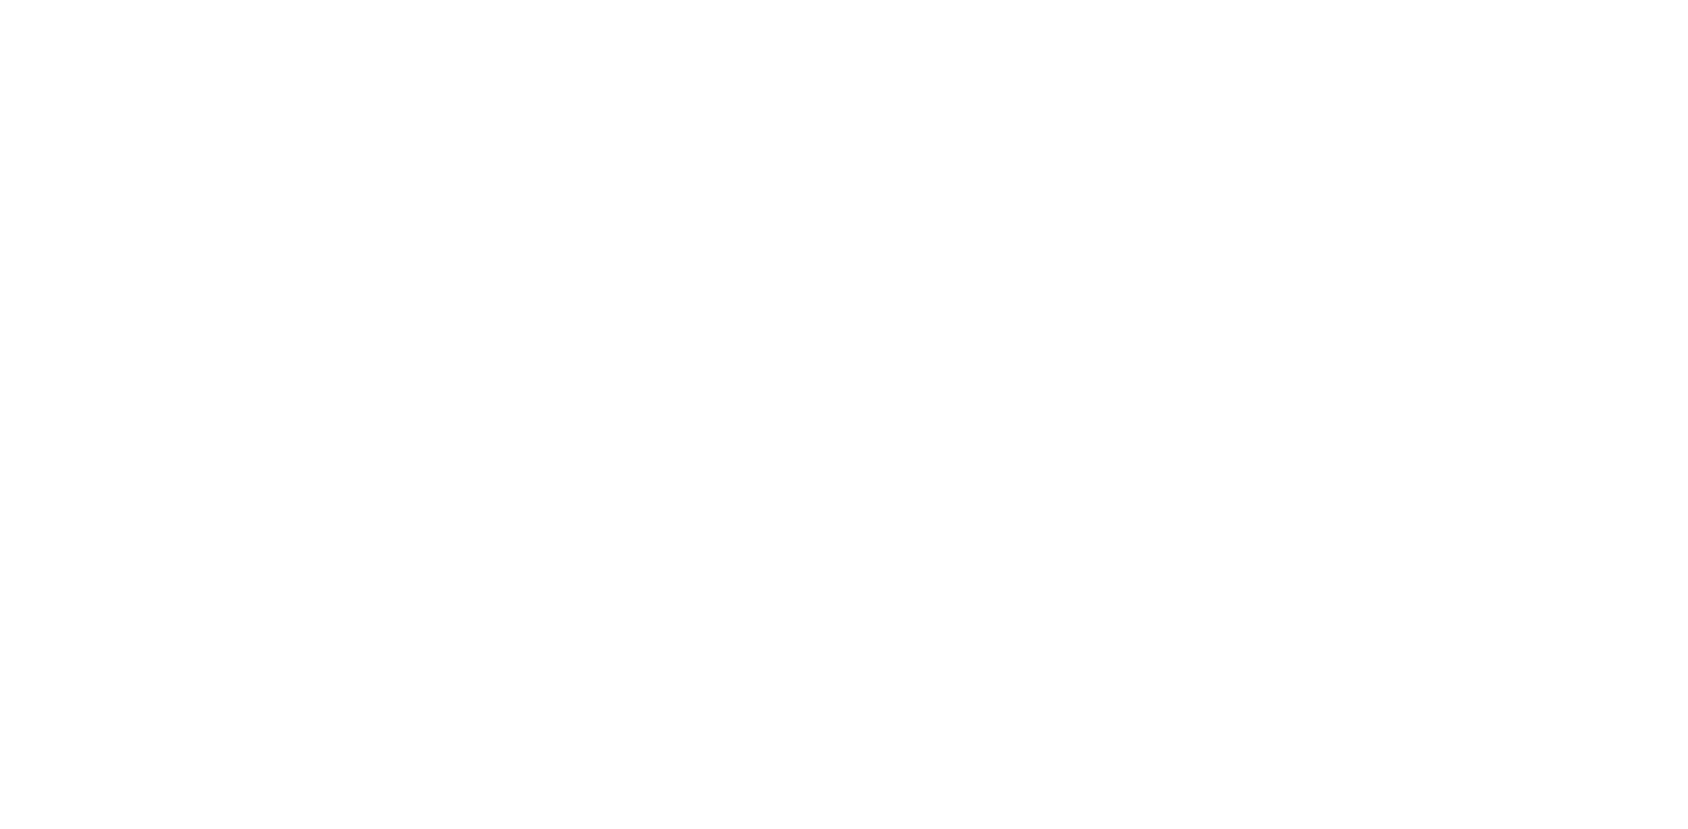

22/06/02 10:20:57 WARN org.apache.spark.deploy.yarn.YarnAllocatorNodeHealthTracker: No available nodes reported, please check Resource Manager.
22/06/02 10:21:00 WARN org.apache.spark.deploy.yarn.YarnAllocatorNodeHealthTracker: No available nodes reported, please check Resource Manager.
22/06/02 10:21:03 WARN org.apache.spark.deploy.yarn.YarnAllocatorNodeHealthTracker: No available nodes reported, please check Resource Manager.
22/06/02 10:21:06 WARN org.apache.spark.deploy.yarn.YarnAllocatorNodeHealthTracker: No available nodes reported, please check Resource Manager.
22/06/02 10:21:09 WARN org.apache.spark.deploy.yarn.YarnAllocatorNodeHealthTracker: No available nodes reported, please check Resource Manager.
22/06/02 10:21:12 WARN org.apache.spark.deploy.yarn.YarnAllocatorNodeHealthTracker: No available nodes reported, please check Resource Manager.
22/06/02 10:21:15 WARN org.apache.spark.deploy.yarn.YarnAllocatorNodeHealthTracker: No available nodes reported, please check Resource M

In [8]:
fig, ax = plt.subplots(figsize=(30, 15))
ax.set_xlim(-25, 140)
ax.set_ylim(10, 75)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.2)


world.plot(ax=ax, color='white', edgecolor='black')
geo_df.plot(ax=ax, column="avg(Tone)", markersize=geo_df["ClusterSize"] / 1e3, legend=True, legend_kwds={'label': "Average Tone", "orientation": "horizontal"}, alpha=0.7, cax=cax);

In [178]:
fig.savefig("tone_zoom.svg")

## Additional Graphs

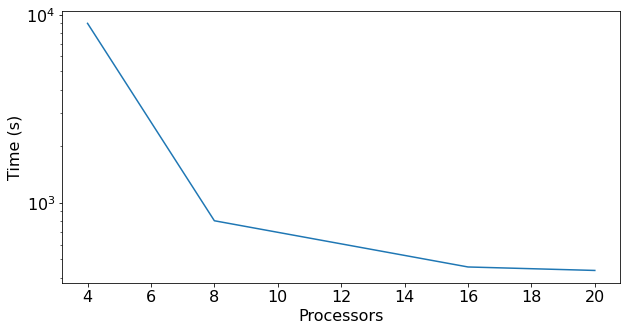

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("Processors")
ax.set_ylabel("Time (s)")
ax.set_yscale('log')

plt.plot([4, 8, 16, 20], [9000, 803, 456, 437]);

In [22]:
fig.savefig("scalability.svg")

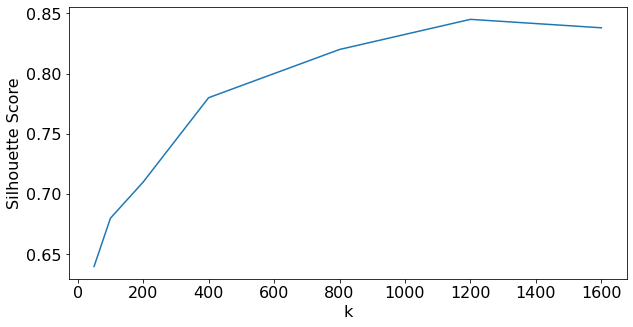

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("k")
ax.set_ylabel("Silhouette Score")

plt.plot([50, 100, 200, 400, 800, 1200, 1600], [0.64, 0.68, 0.71, 0.78, 0.82, 0.845, 0.838]);

In [20]:
fig.savefig("silhouette_full.svg")